In [2]:
import scipy as scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib import gridspec
from numpy.fft import fftshift, ifftshift, ifft2, fft2


# load matlab file
mat = scipy.io.loadmat('kdata1.mat')['kdata1'] #k space already 
mat2 = scipy.io.loadmat('kdata2.mat')['kdata2']

### 1. FFT reconstruction of cartesian MRI data 

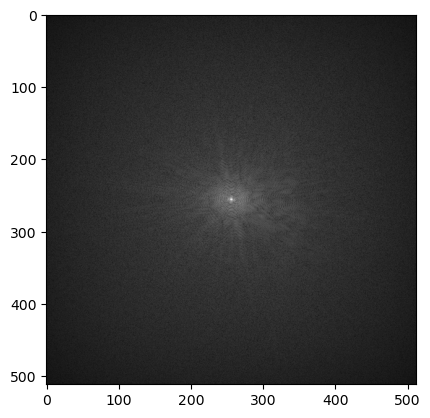

In [3]:
# plot magnitude and phase of reconstructed image 
mag = np.log(abs(mat) + 1) # add 1 so that all values are >= 1
#plt.imshow(mag, cmap = 'gray')
plt.imshow(abs(mat), cmap = 'gray', norm = clr.PowerNorm(gamma = 0.2))

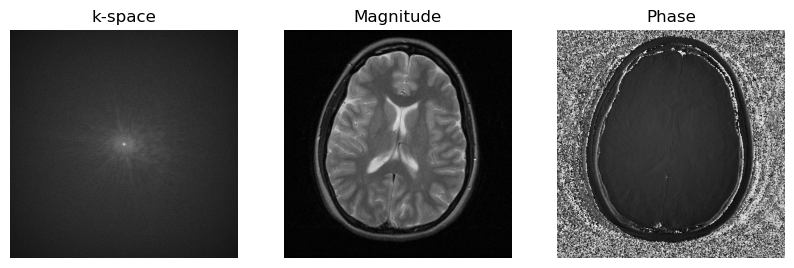

In [43]:
def ifft2c(x, axes = (-2,-1)):
    return np.sqrt(np.size(x))* fftshift(ifft2(ifftshift(x, axes=axes), axes = axes), axes = axes)

def fft2c(x, axes = (-2,-1)):
    return np.sqrt(np.size(x))* fftshift(fft2(fftshift(x, axes=axes), axes = axes), axes = axes)
    
recon = ifft2c(mat)
k_space = fft2c(recon)
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(abs(mat), cmap = 'gray', norm = clr.PowerNorm(gamma = 0.2))
plt.title("k-space")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(abs(recon), cmap = 'gray')
plt.title("Magnitude")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(np.angle(recon),cmap = 'gray',vmin=-np.pi,vmax=np.pi)
plt.title("Phase")
plt.axis("off")
plt.savefig('fft.png')


### 2. Effects of k-space zero-padding and zero padding 

- discuss the effects of k-space truncation

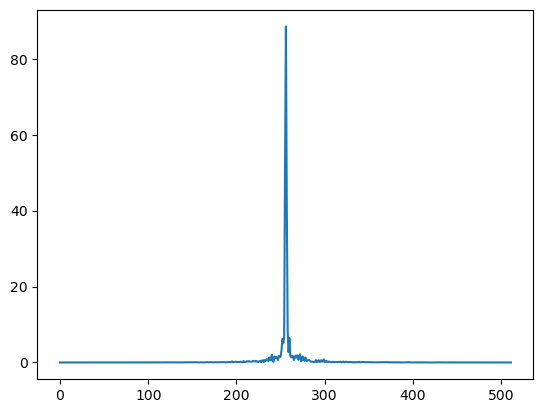

In [5]:
kline = mat[256]
kline.shape 
plt.plot(abs(kline))

C:\Users\navne\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


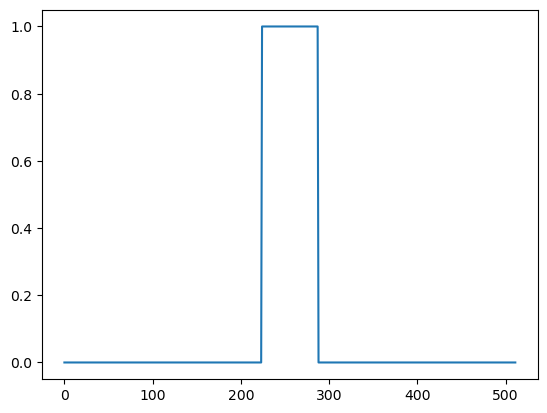

In [6]:
size = 64
length = kline.shape[0]
box = np.zeros_like(kline)
box[length//2 - size//2 : length//2 + size//2] = 1
plt.plot(box)

C:\Users\navne\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


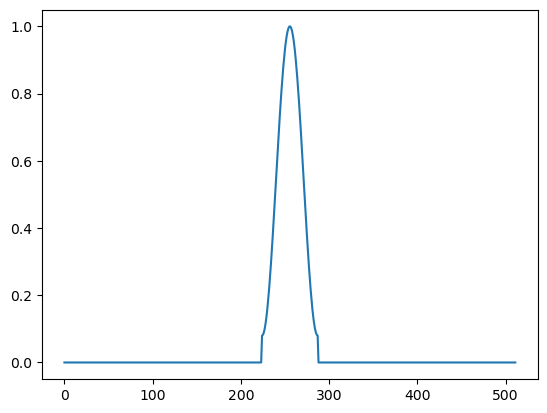

In [7]:
from skimage.filters import window
size = 64
window_1d = np.zeros_like(kline)
hamming = window("hamm", [size])
x,y = (length - size)//2, (length + size)//2
window_1d[x:y] = hamming
plt.plot(window_1d)

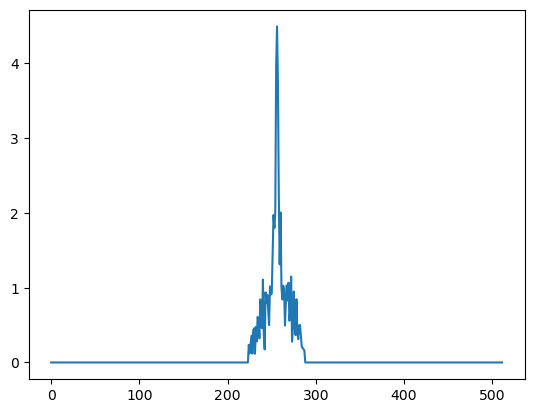

In [8]:
kline64 = kline * box 
plt.plot(np.log(abs(kline64)+1))

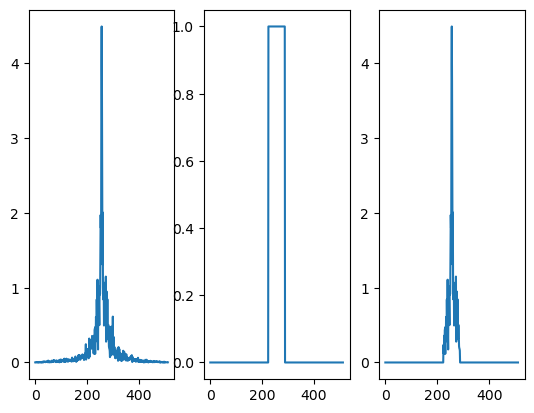

In [9]:
f,a = plt.subplots(1,3)
for i, sig in enumerate([kline, box, kline64]):
    if i != 1:
        a[i].plot(np.log(abs(sig)+1))
    else:
        a[i].plot(abs(sig))
plt.show()         

Takeaways:
- increase in SNR 
- throw out the high frequencies (see a blurry image) 
- gibbs ringing effect because the box filter is a convoltuion with a sinc function 

In [10]:
from skimage.filters import window 

def masking(kspace, size, kshift, type = "box"):
    frame = np.zeros_like(kspace)
    mask = np.ones([size,size]) if type == "box" else window("hamm", [size, size])
    frame_size = frame.shape[0]
    
    x,y = (frame_size - size)//2, (frame_size + size)//2
    frame[x+kshift:y+kshift, x+kshift:y+kshift] = mask
    masked = kspace*frame 
    return masked

def generate_window(kline, size, type = "box"):
    samples = np.zeros_like(kline)
    window_1d = np.ones([size]) if type == "box" else window("hamm", [size])
    length = kline.shape[0]
    x,y = (length - size)//2, (length + size)//2
    samples[x:y] = window_1d
    windowed = kline*samples 
    return windowed, samples
    

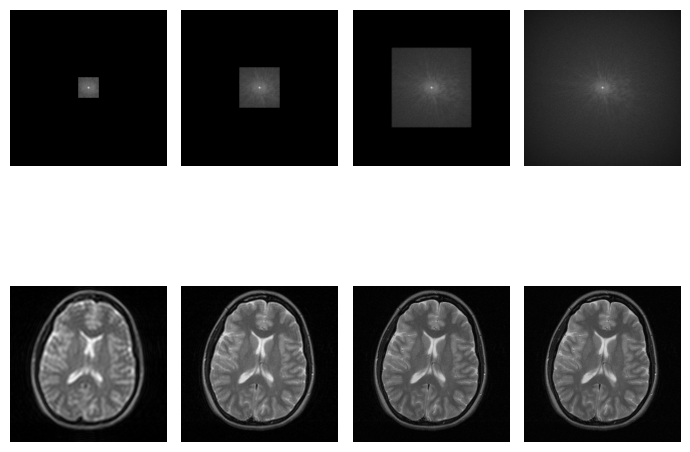

In [11]:
kspace64 = masking(mat, 64,0,"box")
kspace128 = masking(mat, 128,0,"box")
kspace256 = masking(mat, 256, 0,"box")
recon_64 = ifft2c(kspace64)
recon_128 = ifft2c(kspace128)
recon_256 = ifft2c(kspace256)

fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace = .005, wspace=.001) 
for i, img in enumerate([kspace64, kspace128, kspace256, mat, recon_64, recon_128, recon_256, recon]):
    ax = plt.subplot(2, 4, i + 1)
    if i < 4:
        plt.imshow(abs(img), cmap='gray', norm = clr.PowerNorm(gamma = 0.2))
    else :
        plt.imshow(abs(img),cmap = 'gray')
    plt.axis("off")
fig.tight_layout()
plt.show()

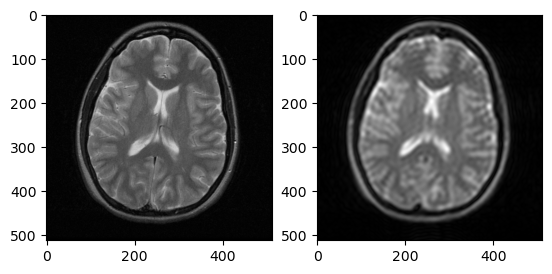

In [12]:
recon_64 = ifft2c(kspace64)

f,a = plt.subplots(1,2)
for i, img in enumerate([recon, recon_64]):
    a[i].imshow(abs(img), cmap = 'gray')
plt.show()

# now do for 128 and for 256

### 3. Point spread function (PSF)

- discuss the differences in spatial resolution

AttributeError: 'numpy.ndarray' object has no attribute 'title'

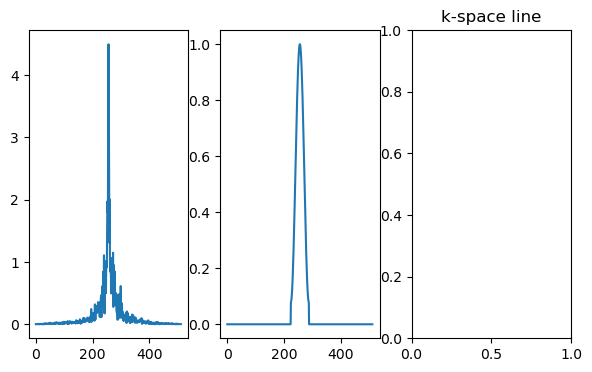

In [58]:
kline64, box64 = generate_window(kline, 64,"box")
kline128, box128 = generate_window(kline, 128,"box")
kline256, box256 = generate_window(kline, 256,"box")
kline64, hamm64 = generate_window(kline, 64,"hamm")
kline128, hamm128 = generate_window(kline, 128,"hamm")
kline256, hamm256 = generate_window(kline, 256,"hamm")
f,a = plt.subplots(1,3, figsize=(7, 4))
for i, sig in enumerate([kline, hamm64, kline64]):
    if i == 0:
        a[i].plot(np.log(abs(sig)+1))
        plt.title("k-space line")
        
    elif i == 1:
        a[i].plot(abs(sig))
        a.title("Hamming window (length=64)")
        
    else:
        a[i].plot(np.log(abs(sig)+1))
        a[i].title.set_text('Windowed k-space')
        
fig.tight_layout()
plt.show()

C:\Users\navne\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\navne\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\navne\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\navne\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\navne\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\navne\anaconda3\

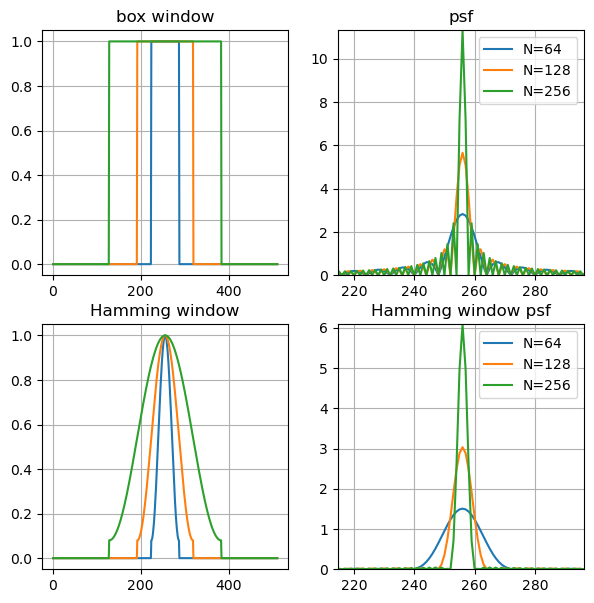

<Figure size 640x480 with 0 Axes>

In [84]:
# ifft of box function is the sinc function : PSF of box function 
psf64 = ifft2c(box64[..., None]).squeeze(1) 
psf128 = ifft2c(box128[..., None]).squeeze(1) 
psf256 = ifft2c(box256[..., None]).squeeze(1) 
psf64_hamm = ifft2c(hamm64[..., None]).squeeze(1) 
psf128_hamm = ifft2c(hamm128[..., None]).squeeze(1) 
psf256_hamm = ifft2c(hamm256[..., None]).squeeze(1) 
#psf_hamming = ifft2c(box64[..., None]).squeeze(1) 
f,a = plt.subplots(2,2,figsize=(7, 7))
plt.grid("on")
a[0,0].plot(box64)
a[0,0].plot(box128)
a[0,0].plot(box256)
a[0, 0].title.set_text('box window')
a[0,0].grid()
a[0,1].plot(abs(psf64))
a[0,1].plot(abs(psf128))
a[0,1].plot(abs(psf256))
a[0,1].margins(x=-0.42, y=0) 
a[0, 1].title.set_text('psf')
a[0,1].legend(['N=64', 'N=128', 'N=256'])
a[0,1].grid()
a[1,0].plot(hamm64)
a[1,0].plot(hamm128)
a[1,0].plot(hamm256)
a[1, 0].title.set_text('Hamming window')
a[1,0].grid()
a[1,1].plot(abs(psf64_hamm))
a[1,1].plot(abs(psf128_hamm))
a[1,1].plot(abs(psf256_hamm))
a[1,1].margins(x=-0.42, y=0)
a[1, 1].title.set_text('Hamming window psf')
a[1,1].legend(['N=64', 'N=128', 'N=256'])
plt.show()
plt.savefig('psf.png')

In [15]:
# Compute FWHM 
#get the maximum 
#argmean - index of the smallest number 
# from scipy.signal import chirp, find_peaks, peak_widths
# peaks, _ = find_peaks(psf)
# results_half = peak_widths(psf, peaks, rel_height=0.5)
# width = results_half[0]
# plt.plot(width)

def FWHM(psf):
    signal_len = len(psf)
    psf_half = psf - np.max(psf)/2 #shifted 
    
    minarg = np.argmin(abs(psf_half))
    
    #half fwhm
    fwhm = minarg - signal_len//2 if minarg > signal_len//2 else signal_len//2 - minarg
    return fwhm*2 

fwhm_64 = FWHM(psf64)
fwhm_128 = FWHM(psf128)
fwhm_256 = FWHM(psf256)
fwhm_64_hamm = FWHM(psf64_hamm)
fwhm_128_hamm = FWHM(psf128_hamm)
fwhm_256_hamm = FWHM(psf256_hamm)
print('FWHM for 64: ', fwhm_64, '| FWHM for hamming 64: ', fwhm_64_hamm)
print('FWHM for 128: ', fwhm_128, '| FWHM for hamming 128: ', fwhm_128_hamm)
print('FWHM for 256: ', fwhm_256, '| FWHM for hamming 256: ', fwhm_256_hamm)


#if you go wider- the psf will be smaller 
# try for 28 and 256 

FWHM for 64:  10 | FWHM for hamming 64:  14
FWHM for 128:  4 | FWHM for hamming 128:  8
FWHM for 256:  2 | FWHM for hamming 256:  4


### 4. k-space filtering (windowing) 

- discuss advantages and disadvantages of the different windows wrt each other
- the effects on resolution and gibbs ringing 

In [ ]:
from skimage.filters import window
# Multiply each truncated k-space data with a Hamming window
#window = window('hann', (512, 512))

kspace64_hamming = masking(mat, 64, 0,'hamming')
recon_64_hamming = ifft2c(kspace64_hamming)
kspace128_hamming = masking(mat, 128, 0, 'hamming')
recon_128_hamming = ifft2c(kspace128_hamming)
kspace256_hamming = masking(mat, 256, 0,'hamming')
recon_256_hamming = ifft2c(kspace256_hamming)
img1 = [recon, recon_64, recon_64_hamming]
img2 = [recon, recon_128, recon_128_hamming]
img3 = [recon, recon_256, recon_256_hamming]



f,a = plt.subplots(3,3,figsize=(8, 8))
a[0,0].imshow(abs(img1[0]), cmap = 'gray')
a[0,0].axis("off")
a[0,0].title.set_text(' original recon')
a[0,1].imshow(abs(img1[1]), cmap = 'gray')
a[0,1].axis("off")
a[0,1].title.set_text('64x64 k-spaces')
a[0,2].imshow(abs(img1[2]), cmap = 'gray')
a[0,2].axis("off")
a[0,2].title.set_text('64x64 Hamming window')

a[1,0].imshow(abs(img2[0]), cmap = 'gray')
a[1,0].axis("off")
a[1,0].title.set_text(' original recon')
a[1,1].imshow(abs(img2[1]), cmap = 'gray')
a[1,1].axis("off")
a[1,1].title.set_text('128x128 k-space')
a[1,2].imshow(abs(img3[2]), cmap = 'gray')
a[1,2].axis("off")
a[1,2].title.set_text('128x128 Hamming window')

a[2,0].imshow(abs(img2[0]), cmap = 'gray')
a[2,0].axis("off")
a[2,0].title.set_text(' original recon')
a[2,1].imshow(abs(img2[1]), cmap = 'gray')
a[2,1].axis("off")
a[2,1].title.set_text('256x256 k-space')
a[2,2].imshow(abs(img3[2]), cmap = 'gray')
a[2,2].axis("off")
a[2,2].title.set_text('256x256 Hamming window')
plt.show()
plt.savefig('k-space_filtering.jpg')



### 5. Oversampling the readout dimension 

- discuss the effect of oversampling

(168, 168)


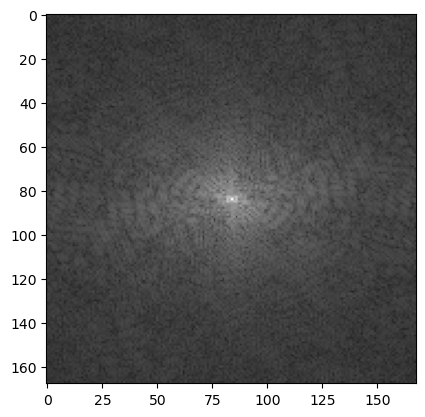

In [18]:
# plot magnitude and phase of reconstructed image 
mag = np.log(abs(mat2[:,::2]) + 1) # add 1 so that all values are >= 1
#plt.imshow(mag, cmap = 'gray')
plt.imshow(abs(mat2[:,::2]), cmap = 'gray', norm = clr.PowerNorm(gamma = 0.2))
print(mag.shape)

(168, 168)


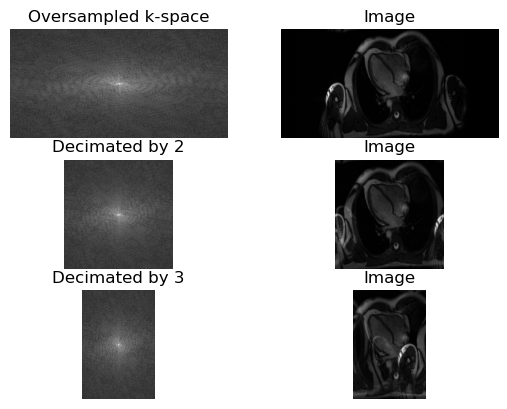

In [36]:
recon2_undersampled_3= ifft2c(mat2[:,::3])
recon2_undersampled_2= ifft2c(mat2[:,::2])
recon2_oversampled= ifft2c(mat2)
plt.subplot(3, 2, 2)
plt.imshow(abs(recon2_oversampled), cmap = 'gray')
plt.title("Image")
plt.axis("off")
plt.subplot(3, 2, 1)
plt.imshow(abs(mat2), cmap = 'gray', norm = clr.PowerNorm(gamma = 0.2))
plt.title("Oversampled k-space")
plt.axis("off")
plt.subplot(3, 2, 4)
plt.imshow(abs(recon2_undersampled_2), cmap = 'gray')
plt.title("Image")
plt.axis("off")
plt.subplot(3, 2, 3)
plt.imshow(abs(mat2[:,::2]), cmap = 'gray', norm = clr.PowerNorm(gamma = 0.2))
plt.title("Decimated by 2")
plt.axis("off")
plt.subplot(3, 2, 6)
plt.imshow(abs(recon2_undersampled_3), cmap = 'gray')
plt.title("Image")
plt.axis("off")
plt.subplot(3, 2, 5)
plt.imshow(abs(mat2[:,::3]), cmap = 'gray', norm = clr.PowerNorm(gamma = 0.2))
plt.title("Decimated by 3")
plt.axis("off")
plt.savefig('Oversampling.png')
print(recon2_undersampled_2.shape)
